In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('AAPL.csv', index_col=0) # Đọc file .csv thành DataFrame
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-22,44.325001,44.445000,44.150002,44.250000,42.077309,108434400
2018-01-23,44.325001,44.860001,44.205002,44.259998,42.086823,130756400
2018-01-24,44.312500,44.325001,43.299999,43.555000,41.416443,204420400
2018-01-25,43.627499,43.737499,42.632500,42.777500,40.677113,166116000
2018-01-26,43.000000,43.000000,42.514999,42.877499,40.772198,156572000


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-12,133.880005,134.259995,131.440002,133.410004,133.410004,71379600
2023-01-13,132.029999,134.919998,131.660004,134.759995,134.759995,57758000
2023-01-17,134.830002,137.289993,134.130005,135.940002,135.940002,63646600
2023-01-18,136.820007,138.610001,135.029999,135.210007,135.210007,69672800
2023-01-19,134.080002,136.250000,133.770004,135.270004,135.270004,58280400


In [4]:
# Khai báo hàm Windowing (dùng để tạo các cặp X, y cho time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = [] # Khai báo list dùng để lưu trữ các y

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx] # Lấy X
        label = df[label_name][label_start_idx:label_end_idx] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

INPUT_SIZE = 30 
LABEL_SIZE = 1
OFFSET = 1
BATCH_SIZE = 64
TARGET_NAME = 'Adj Close'

dataset_length = len(df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window(df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window(df, 
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window(df, 
                                  df_start_idx=VAL_END_IDX,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization()
normalize_layer.adapt(np.vstack((X_train, X_val, X_test)))

In [5]:
# Xây dựng hàm khởi tạo mode
def build_model(input_shape, output_size):
    model = tf.keras.Sequential([
        # Input layer 
        tf.keras.Input(shape=input_shape, name='input_layer'), 

        normalize_layer,

        # BiLSTM Layer 1 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, 
                                                           return_sequences=True, 
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='lstm_layer_1'), 

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, 
                                                           return_sequences=True, 
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='lstm_layer_2'),          

        # BiLSTM Layer 3
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, 
                                                           return_sequences=False, 
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='lstm_layer_3'),   
                            
        # FC Layer 1
        tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fc_layer_1'
                              ),
        
        # Output Layer
        tf.keras.layers.Dense(output_size, 
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer') 
    ],
    name='lstm_model')

    return model

In [6]:
INPUT_SHAPE = X_train.shape[-2:] 
model = build_model(INPUT_SHAPE,
                    LABEL_SIZE)
model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 30, 6)            13        
 n)                                                              
                                                                 
 lstm_layer_1 (Bidirectional  (None, 30, 256)          138240    
 )                                                               
                                                                 
 lstm_layer_2 (Bidirectional  (None, 30, 128)          164352    
 )                                                               
                                                                 
 lstm_layer_3 (Bidirectional  (None, 64)               41216     
 )                                                               
                                                                 
 fc_layer_1 (Dense)          (None, 32)                2

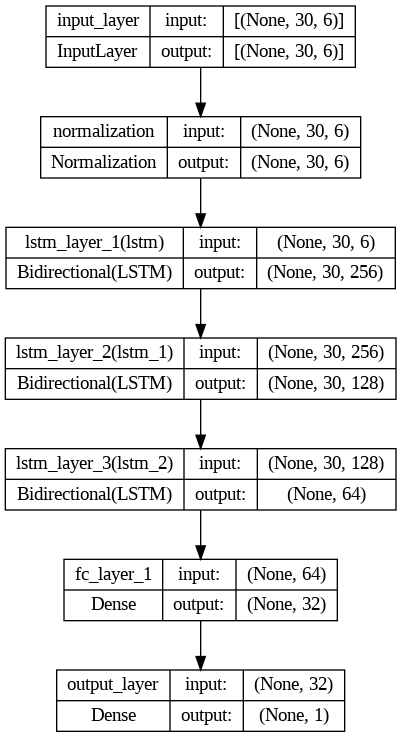

In [7]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [8]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 500
LR = 1e-3

In [9]:
# Cấu hình một số thông tin cho mô hình
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.MeanSquaredError(), # Sử dụng hàm loss Mean Squared Error
)

In [10]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/500
14/14 [==============================] - 19s 193ms/step - loss: 1447.0101 - val_loss: 13083.4658
Epoch 2/500
14/14 [==============================] - 0s 20ms/step - loss: 8110.1650 - val_loss: 2681.0713
Epoch 3/500
14/14 [==============================] - 0s 19ms/step - loss: 15487.7891 - val_loss: 247.4736
Epoch 4/500
14/14 [==============================] - 0s 20ms/step - loss: 7280.3809 - val_loss: 23270.5156
Epoch 5/500
14/14 [==============================] - 0s 18ms/step - loss: 5960.0991 - val_loss: 22652.4941
Epoch 6/500
14/14 [==============================] - 0s 19ms/step - loss: 5683.1123 - val_loss: 22059.5879
Epoch 7/500
14/14 [==============================] - 0s 19ms/step - loss: 5421.6226 - val_loss: 21490.6660
Epoch 8/500
14/14 [==============================] - 0s 21ms/step - loss: 5174.7725 - val_loss: 20944.6504
Epoch 9/500
14/14 [==============================] - 0s 18ms/step - loss: 4941.7534 - val_loss: 20420.5176
Epoch 10/500
14/14 [=================

In [11]:
def mae(y_true, y_pred):
    mae = np.mean(np.abs((y_true - y_pred)))

    return mae

def mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)

    return mse

def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))

    return rmse

def mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true-y_pred) / y_true)) * 100

    return mape

In [12]:
y_test_pred = model.predict(X_test, verbose=0)
print(f'RMSE: {rmse(y_test, y_test_pred)}')
print(f'MAPE: {mape(y_test, y_test_pred)}')
print(f'MSE: {mse(y_test, y_test_pred)}')
print(f'MAE: {mae(y_test, y_test_pred)}')

RMSE: 65.80725310474884
MAPE: 45.112390095985525
MSE: 4330.594561192475
MAE: 65.23216856699842


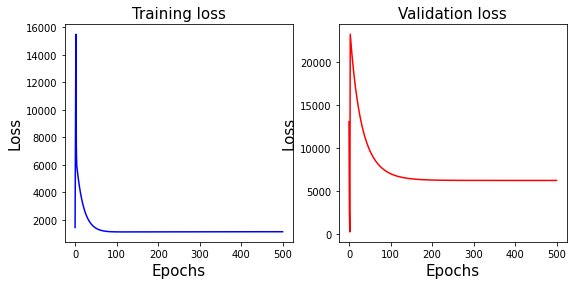

In [13]:
train_loss = history.history['loss']# Đọc thông tin loss trên tập train
val_loss = history.history['val_loss'] # Đọc thông tin loss trên tập val

plt.figure(figsize=(9, 4)) # Cài đặt kích thước khung ảnh

plt.subplot(1, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs',fontsize=15) # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss',fontsize=15) # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss',fontsize=15) # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='blue') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(1, 2, 2) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs',fontsize=15) # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss',fontsize=15) # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss',fontsize=15) # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='red') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.show() # Hiển thị 2 khung ảnh nhỏ

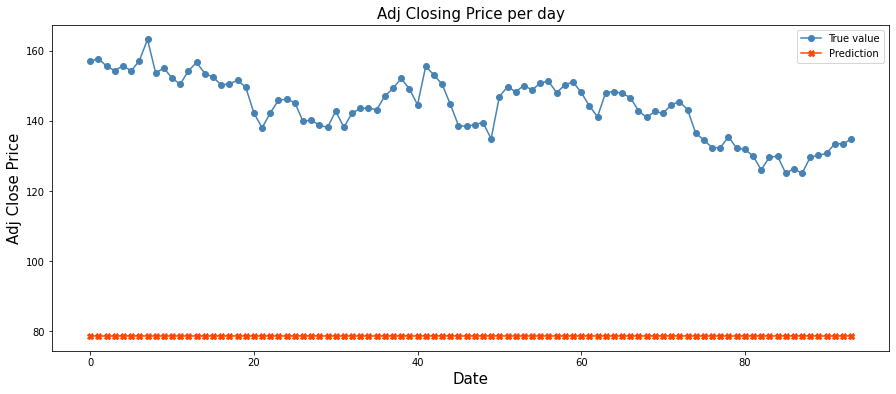

In [14]:
def plot_difference(y, pred):
    plt.figure(figsize=(15, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')
    plt.title('Adj Closing Price per day', fontsize=15, fontname='Times New Roman')
    plt.xlabel('Date', fontsize=15, fontname='Times New Roman')
    plt.ylabel('Adj Close Price', fontsize=15, fontname='Times New Roman')
    plt.legend()
    plt.show()
  
plot_difference(y_test[:300], model.predict(X_test[:300], verbose=0))